---
title: 04 Topographic Position Index 
description: Calculating Topographic position index 
authors:
  - name: Ryan E Lima
    orcid: 0000-0002-5352-7215
---

# Overview of Topographic Position Index or TPI


* Used to identify hills and valleys in a DEM

* Compared elevation at a cell with average elevation in a circular neighborhood around that cell

* Positive TPI values mean the cell is higher than neighbors
    * Such as Hills or Ridgelines
    
* Negative TPI values mean the cell is lower than neighbors
    * Such as valleys, sinks, or drainages

> For more info see:

* Raster Lab 5: Calculating TPI, or Topographic Position Index, in ArcGIS Pro [Youtube video](https://www.youtube.com/watch?v=v7TQ4n5HPPg)


## Install Packages

In [3]:
#!pip install numpy opencv-python rasterio matplotlib requests tqdm scikit-image


  Using cached tqdm-4.67.0-py3-none-any.whl.metadata (57 kB)


## Load Libraries

In [4]:
import os
import numpy as np
import cv2
import rasterio
import matplotlib.pyplot as plt
from scipy.ndimage import convolve, generic_filter
from skimage import exposure
from tqdm import tqdm
from pyproj import CRS
import requests


In [5]:
# URL of the DEM
DEM_URL = 'https://prd-tnm.s3.amazonaws.com/StagedProducts/Elevation/1/TIFF/historical/n35w112/USGS_1_n35w112_20240402.tif'
dem_path = 'Data/USGS_1_n35w112_20240402.tif'

# Download DEM if not present
if not os.path.exists(dem_path):
    print("Downloading DEM...")
    response = requests.get(DEM_URL, stream=True)
    with open(dem_path, 'wb') as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)
    print("Download complete.")

# Load DEM
with rasterio.open(dem_path) as src:
    dem = src.read(1)
    profile = src.profile


Download complete.


In [6]:
def query_raster_info(raster):
    """Queries raster metadata and prints details."""
    if isinstance(raster, str):  # Path to raster
        with rasterio.open(raster) as src:
            profile = src.profile
            transform = src.transform
            crs = src.crs
    elif isinstance(raster, rasterio.io.DatasetReader):
        profile = raster.profile
        transform = raster.transform
        crs = raster.crs
    elif isinstance(raster, np.ndarray):
        print(f"Data Type: {raster.dtype}, Shape: {raster.shape}")
        return
    else:
        raise ValueError("Input must be a path, rasterio object, or NumPy array.")

    units = CRS.from_wkt(crs.to_wkt()).axis_info[0].unit_name if crs else 'Unknown'
    print(f"Driver: {profile['driver']}, Data Type: {profile['dtype']}")
    print(f"Resolution: {transform[0]} x {abs(transform[4])} {units}")
    print(f"Projection: {profile['crs']}")


In [7]:
def create_neighborhood(shape='circle', size=5):
    """Create a square or circular neighborhood."""
    if shape == 'square':
        return np.ones((size, size))
    elif shape == 'circle':
        y, x = np.ogrid[-size//2:size//2+1, -size//2:size//2+1]
        return (x**2 + y**2) <= (size//2)**2
    else:
        raise ValueError("Invalid shape. Choose 'square' or 'circle'.")

def apply_filter(dem, footprint, filter_type='mean'):
    """Apply filter using convolution."""
    if filter_type == 'mean':
        return convolve(dem, footprint / footprint.sum(), mode='constant', cval=np.nan)
    elif filter_type in ['median', 'max', 'min']:
        filter_funcs = {'median': np.nanmedian, 'max': np.nanmax, 'min': np.nanmin}
        return generic_filter(dem, filter_funcs[filter_type], footprint=footprint, mode='constant', cval=np.nan)
    else:
        raise ValueError("Invalid filter type.")


In [8]:
def plot_raster(data, title='Raster', cmap='viridis', clip_percentiles=(1, 99), equalize_hist=True):
    """Plot raster data with optional histogram equalization."""
    vmin = np.nanpercentile(data, clip_percentiles[0])
    vmax = np.nanpercentile(data, clip_percentiles[1])
    data_clipped = np.clip(data, vmin, vmax)
    data_no_nan = np.nan_to_num(data_clipped, nan=vmin)
    
    if equalize_hist:
        data_eq = exposure.equalize_hist(data_no_nan) * 255
        plt.imshow(data_eq, cmap=cmap)
    else:
        plt.imshow(data_no_nan, cmap=cmap, vmin=vmin, vmax=vmax)
    
    plt.title(title)
    plt.colorbar(label='Value')
    plt.show()


In [9]:
def calculate_tpi(original_dem, filtered_dem, normalize=False):
    """Calculate TPI and optionally normalize to 0-255."""
    tpi = original_dem - filtered_dem
    if normalize:
        tpi_min, tpi_max = np.nanmin(tpi), np.nanmax(tpi)
        return ((tpi - tpi_min) / (tpi_max - tpi_min) * 255).astype(np.uint8)
    return tpi


In [10]:
def try_neighborhood_sizes(dem, sizes, shape='circle', normalize=False):
    """Apply multiple neighborhood sizes and plot TPI."""
    footprint1 = create_neighborhood(shape=shape, size=3) # smooth the DEM first with 3x3 mean smoothing
    smoothed_dem = apply_filter(dem, footprint1, filter_type='mean')
    for size in sizes:
        footprint2 = create_neighborhood(shape=shape, size=size)
        filtered_dem = apply_filter(dem, footprint2, filter_type='mean')
        tpi = calculate_tpi(smoothed_dem, filtered_dem, normalize=normalize)
        plot_raster(tpi, title=f'TPI with {shape}, size={size}', cmap='viridis')


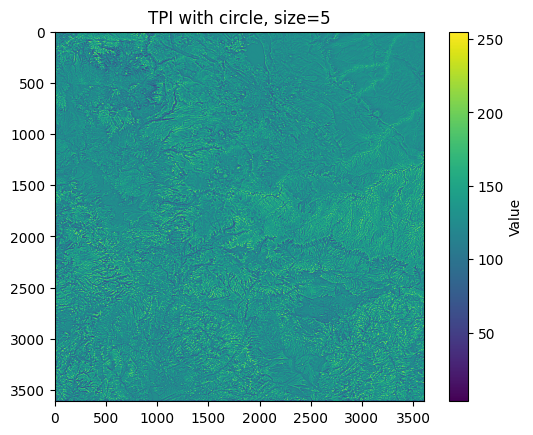

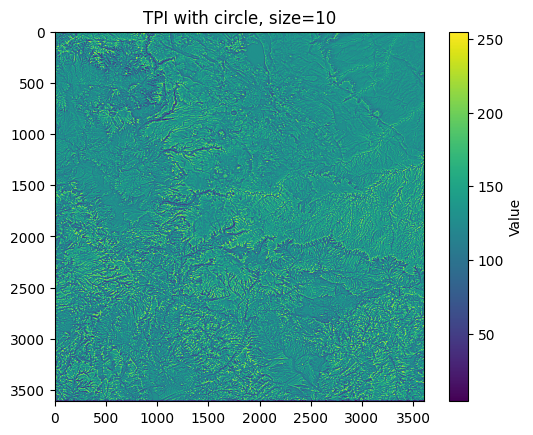

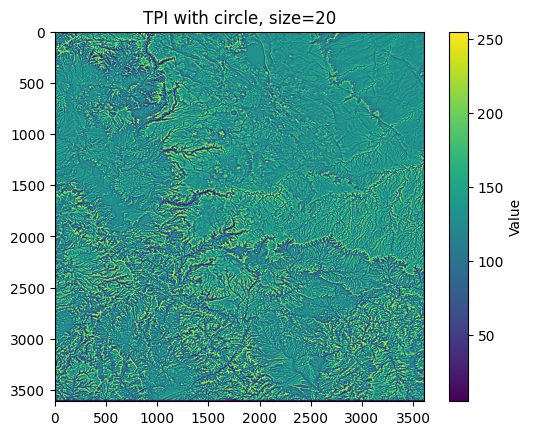

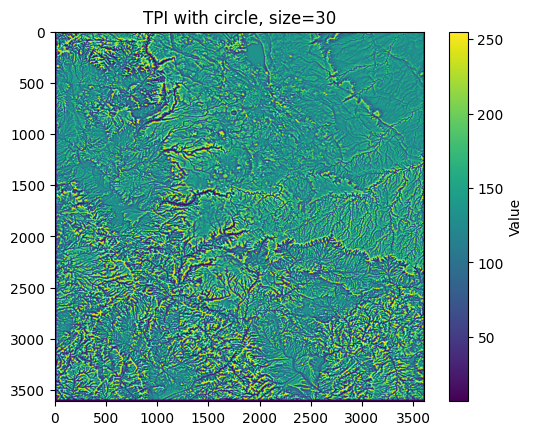

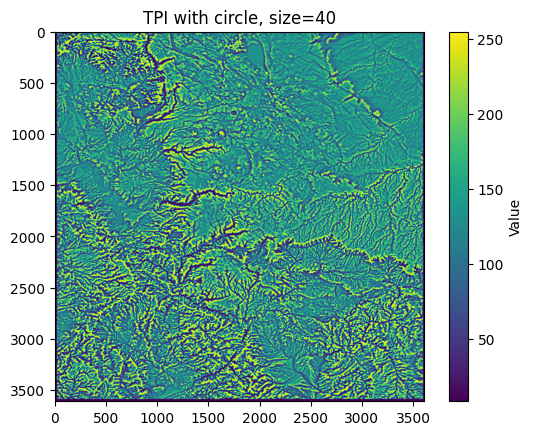

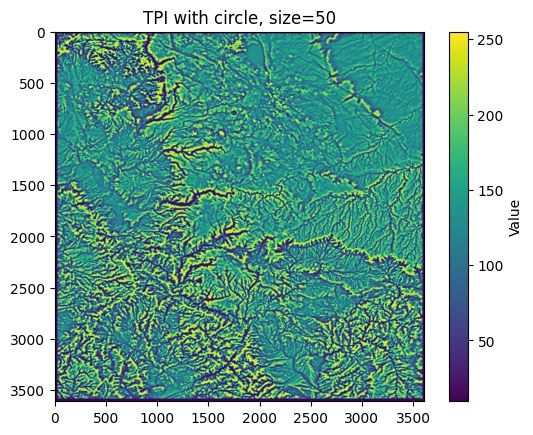

In [11]:
sizes = [5, 10, 20, 30, 40, 50] # try different mean filter sizes for TPI
try_neighborhood_sizes(dem, sizes)
